In [1]:
import pandas as pd
import numpy as np
import glob, os, sys
import xlrd
import json
import  asposecells     


In [2]:
pd.set_option('display.max_rows',50)
pd.set_option('display.max_columns',50)

In [3]:
with open("limit_ttl.json", 'r', encoding='utf-8') as file:
    limt_ttl = json.load(file)
    print(type(limt_ttl))
    print(limt_ttl)


<class 'dict'>
{'AC 220V 전원 인가': {'ucl': 0.0, 'lcl': 0.0}, 'AC 220V 전원 검사': {'ucl': 230.0, 'lcl': 210.0}, 'DC12V 전원 검사': {'ucl': 12.36, 'lcl': 11.64}, 'DC 5V 전원 검사': {'ucl': 5.15, 'lcl': 4.85}, 'TEST 시작': {'ucl': 1.0, 'lcl': 1.0}, 'COM0 MODE TTL': {'ucl': 1.0, 'lcl': 1.0}, 'H/W MODEL': {'ucl': 16.0, 'lcl': 16.0}, 'F/W VERSION': {'ucl': 0.46, 'lcl': 0.46}, 'UNIT TYPE': {'ucl': 1.0, 'lcl': 1.0}, 'EEPROM CHECK': {'ucl': 1.0, 'lcl': 1.0}, 'COM0 TEST': {'ucl': 1.0, 'lcl': 1.0}, 'COM1 TEST': {'ucl': 1.0, 'lcl': 1.0}, 'SENSOR0 (TRA)': {'ucl': 3.3, 'lcl': 2.8}, 'SENSOR1 (TDF)': {'ucl': 3.5, 'lcl': 3.1}, 'RELAY0 COMP ON': {'ucl': 1.0, 'lcl': 1.0}, 'RELAY0 COMP OFF': {'ucl': 0.0, 'lcl': 0.0}, 'RELAY2 DEF ON': {'ucl': 1.0, 'lcl': 1.0}, 'RELAY2 DEF OFF': {'ucl': 0.0, 'lcl': 0.0}, 'RELAY3 FAN ON': {'ucl': 1.0, 'lcl': 1.0}, 'RELAY3 FAN OFF': {'ucl': 0.0, 'lcl': 0.0}, 'DISP MOSI HIGH': {'ucl': 5.15, 'lcl': 4.85}, 'DISP MOSI LOW': {'ucl': 0.15, 'lcl': 0.0}, 'DISP MISO HIGH': {'ucl': 5.15, 'lcl': 4.85}

In [37]:
df = pd.read_csv('com_ttl.csv')

In [38]:
df.Status.value_counts()

OK                                                                    4943
JP1.1                                                                  374
CN9.3, DC전압 검출                                                         249
0 : NO TEST 1 : TEST 진행중 2 : TEST 완료                                   202
K1.1                                                                   108
CN9.4, DC전압 검출                                                          27
CN5.1(19.8KΩ), 3.046Volt                                                13
CN2.7, AC전압 검출                                                          13
U2.8, DC전압 검출                                                           12
CN9.6, DC전압 검출                                                          11
0:X(x)1A, 2:X(x)1C, 4:X(x)1E1:X(x)2B, 3:X(x)2D, 5:X(x)2F, 6:X(x)2G       8
CN9.5, DC전압 검출                                                           7
CN6.1(25.2KΩ), 3.328Volt                                                 6
CN2.5, AC전압 검출           

In [39]:
df.Status.isna().sum()

205

In [40]:
df.dropna(subset=['Status'],axis=0, inplace=True)

In [41]:
df['COM0 MODE TTL'].unique()

array([nan])

In [42]:
df.loc[df[(df['Status']=='CN3')|(df['Status']=='K1.1')|(df['Status']=='JP1.1')|(df['Status']=='0 : NO TEST 1 : TEST 진행중 2 : TEST 완료 ')].index, 'COM0 MODE TTL']=0

In [43]:
df['COM0 MODE TTL'].fillna(1, inplace=True)

In [44]:
df['COM0 MODE TTL'].unique()

array([1., 0.])

In [45]:
df.drop(['date.1','qty.1'], axis=1, inplace=True)

In [46]:
df.Status.unique()

array(['CN9.3, DC전압 검출', 'OK', '0 : NO TEST 1 : TEST 진행중 2 : TEST 완료 ',
       'JP1.1', 'CN5.1(19.8KΩ), 3.046Volt', 'CN2.7, AC전압 검출',
       'CN9.4, DC전압 검출',
       '0:X(x)1A, 2:X(x)1C, 4:X(x)1E1:X(x)2B, 3:X(x)2D, 5:X(x)2F, 6:X(x)2G',
       'CN9.5, DC전압 검출', 'CN9.6, DC전압 검출', 'CN6.1(25.2KΩ), 3.328Volt',
       'K1.1', 'U2.8, DC전압 검출', 'CN2.5, AC전압 검출', 'CN3',
       '표현방법( #.## ) , (0:0.00 , 255:2.55)'], dtype=object)

In [47]:
## 검사 중 On/Off 검사 제외 수치 검사 항목 만 추리고, 해당 검사의 defect에 해당하는 항목을 list로 구성함.

numeric = ['DC12V 전원 검사', 'DC 5V 전원 검사', 'SENSOR0 (TRA)', 
           'SENSOR1 (TDF)', 'DISP MOSI HIGH', 'DISP MISO HIGH', 'DISP CLK HIGH', 'DISP STB HIGH']

defect = ['K1.1','JP1.1','CN5.1(19.8KΩ), 3.046Volt', 'CN6.1(25.2KΩ), 3.328Volt', 'CN9.3, DC전압 검출', 'CN9.4, DC전압 검출', 'CN9.5, DC전압 검출', 'CN9.6, DC전압 검출']

In [48]:
#각 검사 단계 별로 data를 분할 함.

df_list = dict()

for n, d in zip(numeric, defect):
    df_list[n] = pd.DataFrame(df[(df['Status']==d) | (df['Status']=='OK')][['date','qty',n, 'Status']]).reset_index(drop=True)

In [49]:
df_list

{'DC12V 전원 검사':           date     qty  DC12V 전원 검사 Status
 0     20230215   94008        12.03     OK
 1     20230215   94133        12.01     OK
 2     20230215   94206        12.03     OK
 3     20230215   94240        12.00     OK
 4     20230215   94332        12.02     OK
 ...        ...     ...          ...    ...
 5046  20230215  113357        12.11     OK
 5047  20230215  113424        12.03     OK
 5048  20230215  113455        12.03     OK
 5049  20230215  113530        12.01     OK
 5050  20230215  114544        12.02     OK
 
 [5051 rows x 4 columns],
 'DC 5V 전원 검사':           date     qty  DC 5V 전원 검사 Status
 0     20230215   94008         5.05     OK
 1     20230215   94133         5.04     OK
 2     20230215   94206         5.11     OK
 3     20230215   94240         5.06     OK
 4     20230215   94332         5.07     OK
 ...        ...     ...          ...    ...
 5312  20230215  113424         5.04     OK
 5313  20230215  113455         5.08     OK
 5314  20230215  1

In [17]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['font.family'] ='Malgun Gothic'

matplotlib.rcParams['axes.unicode_minus'] =False

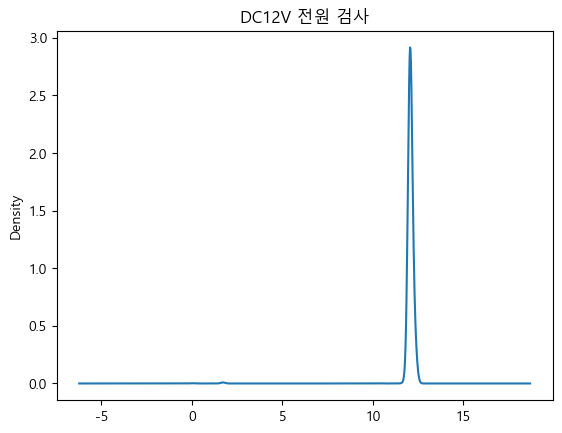

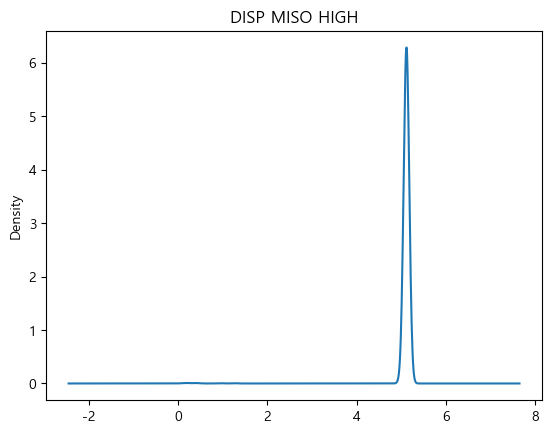

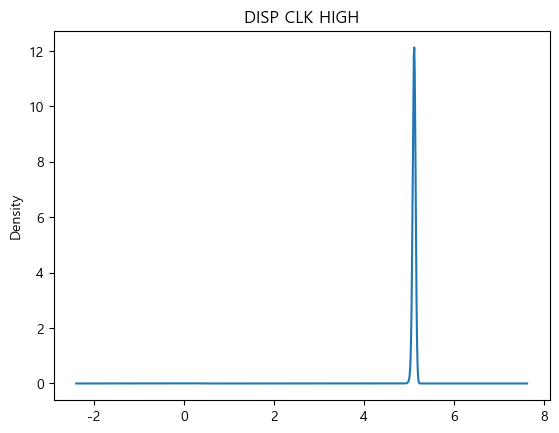

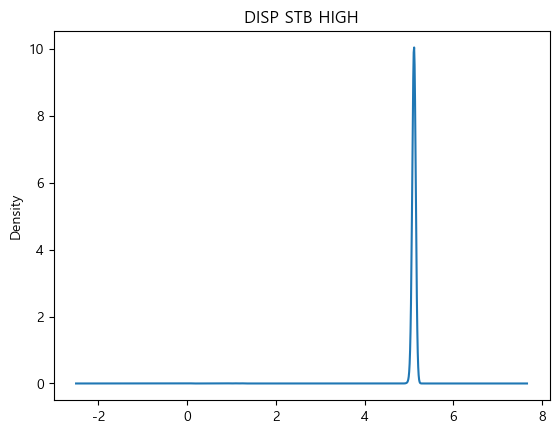

In [82]:
# 각 검사 data 의 분포를 확인 하기 위함.

for k, v in df_list.items():
    plt.figure()
    v[k].plot(kind='density')
    plt.title(k)
    plt.show()


In [18]:
from scipy.stats import kstest, normaltest, shapiro, anderson

# box plot 을 통해 outlier 확인하기 위함
def boxplot_whiskers(x):
    plt.figure()
    boxplot = plt.boxplot(x)
    boxplot_whiskers = [item.get_ydata() for item in boxplot['whiskers']]
    return(boxplot_whiskers)

def outlier_check(x):
    y = boxplot_whiskers(x)
    print(np.min(y), np.max(y))
    sigma_3_p = np.mean(x) + 3*np.std(x) 
    sigma_3_m = np.mean(x) - 3*np.std(x)
    print('3 sigma range :',sigma_3_m, sigma_3_p)
    out_idx = np.where(x>=sigma_3_p)[0]
    out_values = x[out_idx]
    plt.figure()
    boxplot = plt.boxplot(x[-out_idx])
    return(pd.DataFrame({'outlier_index': out_idx,'outliers': out_values}))


In [31]:
def Significance_Test(df_in):
    
    test_stat, p_val = shapiro(df_in)
    ks_stat, p_valks = kstest(df_in, 'norm')
    nm_stat, p_valnm = normaltest(df_in)

    print("SHAPIRO Result : test-statistics : {}, p-value : {}".format(test_stat, p_val))
    print("KS Result : test-statistics : {}, p-value : {}".format(ks_stat, p_valks))
    print("Normal Result : test-statistics : {}, p-value : {}".format(nm_stat, p_valnm))

    test_res1 = anderson(df_in, dist = 'norm')
    print(test_res1)

In [63]:
def statistic_anomaly_detection(df_in, process, upper_sig=2, under_sig=3):
    mean = df_in[process].mean()
    std = df_in[process].std()
    test_des = df_in[(df_in[process] < (mean+(3*std))) & (df_in[process] > (mean-(3*std)))][process].describe()
    display(test_des)
    print()
    print()
    print('mean ', test_des['mean'])

    usl, lsl = test_des['mean'] + (upper_sig*test_des['std']), test_des['mean'] - (under_sig*test_des['std'])
    ucl, lcl = limt_ttl[process]['ucl'], limt_ttl[process]['lcl']
    print(f"usl: {usl}, lsl: {lsl}")
    print(f"ucl: {ucl}, lcl: {lcl}")

    print()
    print()
    test_df_c = df_in.copy()


    anomal_upper = test_df_c[test_df_c[process]>= usl].index
    anomal_under = test_df_c[test_df_c[process]<= lsl].index
    test_df_c['anomal_detection'] = 0
    test_df_c.loc[anomal_upper, 'anomal_detection'] = 2
    test_df_c.loc[anomal_under, 'anomal_detection'] =1
    test_df_c.reset_index(drop=True, inplace=True)
    display(test_df_c)



    print()
    print()
    mask = test_df_c['anomal_detection'].values
    print(mask)

    anom_idx = test_df_c[(test_df_c['anomal_detection'] != 0)].index
    y_idx = test_df_c[(test_df_c['Status'] != 'OK')].index
    plt.figure(figsize=(20,10))
    plt.plot(test_df_c.loc[:,process], '.k')

    plt.plot(test_df_c.loc[y_idx,process], '^', color='g', label='y_true')

    plt.plot(test_df_c.loc[anom_idx,process], '.r', label ='y_pred')
    plt.axhline(y=usl, color='b', linestyle = '-.', label='data_based_USL')
    plt.axhline(y=lsl, color='b', linestyle = '-.')

    plt.axhline(y=ucl, color='r', linestyle = '-.', label = 'spec')
    plt.axhline(y=lcl, color='r', linestyle = '-.')
    plt.title(process)
    plt.legend()


## 'DC12V 전원 검사'

In [56]:
process = 'DC12V 전원 검사'

df_new = df_list[process]
print(df_new.isna().sum())
display(df_new[df_new[process].isna()==True])
## na가 확인 되므로 처리해야한다.
## 특히 해당 검사에서 문제가 발생된 항목의 NA이므로 OK가 아닌 값들의 평균으로 채워 준다.

date           0
qty            0
DC12V 전원 검사    1
Status         0
dtype: int64


date     qty  DC12V 전원 검사 Status
1783  20230323  201505          NaN   K1.1

In [57]:

na_v = df_new[df_new['Status']!='OK'][process].mean() # OK가 아닌 값들의 평균 구하기
df_new[process].fillna(na_v,inplace = True) # 구한 평균으로 NA자리를 채운다.

In [24]:
Significance_Test(df_in=df_new[process])

SHAPIRO Result : test-statistics : 0.09887492656707764, p-value : 0.0
KS Result : test-statistics : 0.9968323104335776, p-value : 0.0
Normal Result : test-statistics : 10255.335529749633, p-value : 0.0
AndersonResult(statistic=1390.718400341374, critical_values=array([0.576, 0.655, 0.786, 0.917, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))


d:\MHC\2022\개인자료\kmong\lstm_즐거운샤프란\power_venv\p_venv\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


통계검정 해석 :
P-value < 0.05 이므로 해당 data는 정규분포를 따른다는 귀무 가설을 기각할 수 있습니다.

11.91 12.23
3 sigma range : 10.219834494193814 13.886506361785477


Empty DataFrame
Columns: [outlier_index, outliers]
Index: []

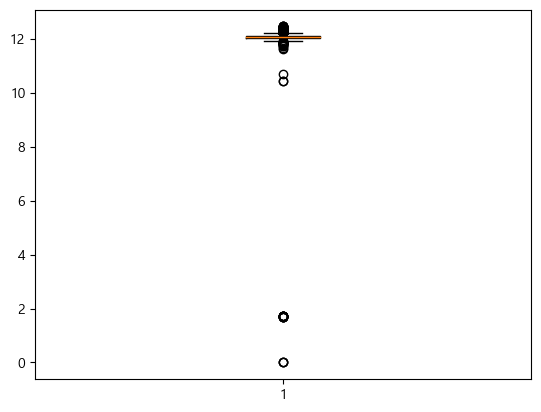

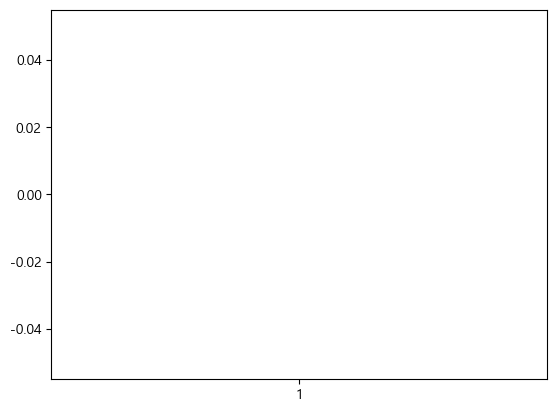

In [25]:

outlier_check(df_new[process].values)

count    5035.000000
mean       12.087067
std         0.102531
min        10.420000
25%        12.030000
50%        12.060000
75%        12.110000
max        12.460000
Name: DC12V 전원 검사, dtype: float64



mean  12.087067295288124
usl: 12.29212871235993, lsl: 11.779475169680417
ucl: 12.36, lcl: 11.64




date     qty  DC12V 전원 검사 Status  anomal_detection
0     20230215   94008        12.03     OK                 0
1     20230215   94133        12.01     OK                 0
2     20230215   94206        12.03     OK                 0
3     20230215   94240        12.00     OK                 0
4     20230215   94332        12.02     OK                 0
...        ...     ...          ...    ...               ...
5046  20230215  113357        12.11     OK                 0
5047  20230215  113424        12.03     OK                 0
5048  20230215  113455        12.03     OK                 0
5049  20230215  113530        12.01     OK                 0
5050  20230215  114544        12.02     OK                 0

[5051 rows x 5 columns]



[0 0 0 ... 0 0 0]


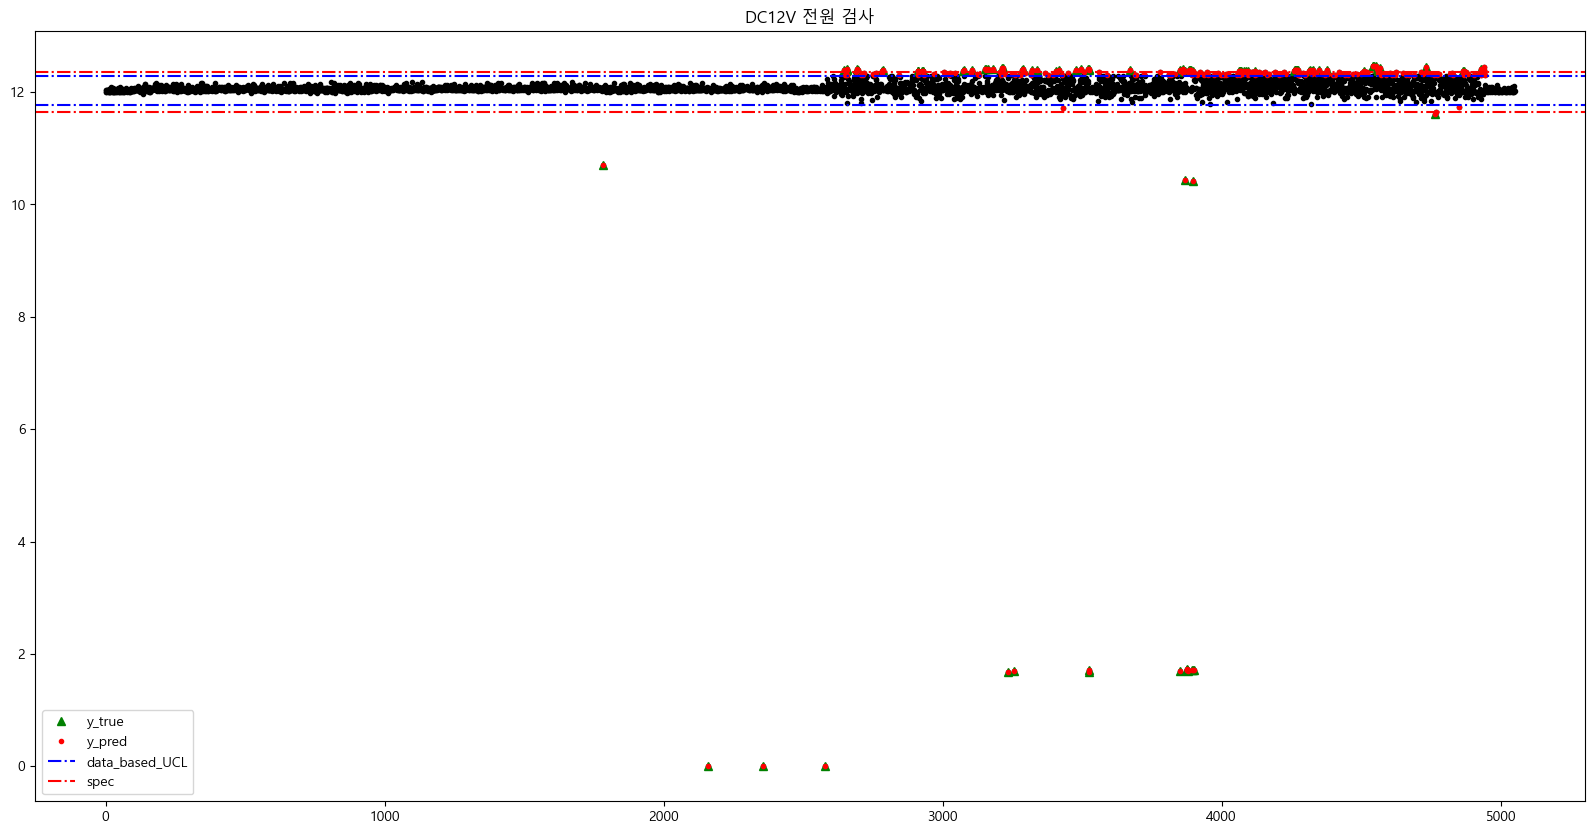

In [33]:
statistic_anomaly_detection(df_in=df_new, process=process, upper_sig=2, under_sig=3)

## 'DC 5V 전원 검사'

In [58]:
process = 'DC 5V 전원 검사'

df_new = df_list[process]

df_new.isna().sum()

date           0
qty            0
DC 5V 전원 검사    0
Status         0
dtype: int64

In [59]:
Significance_Test(df_in=df_new[process])

SHAPIRO Result : test-statistics : 0.2764361500740051, p-value : 0.0
KS Result : test-statistics : 0.9409251978131884, p-value : 0.0
Normal Result : test-statistics : 3992.8823629780513, p-value : 0.0
AndersonResult(statistic=1751.9520768927414, critical_values=array([0.576, 0.656, 0.786, 0.917, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))


d:\MHC\2022\개인자료\kmong\lstm_즐거운샤프란\power_venv\p_venv\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


4.93 5.17
3 sigma range : 1.2039121166040538 8.322332006021487
{'ucl': 5.15, 'lcl': 4.85}


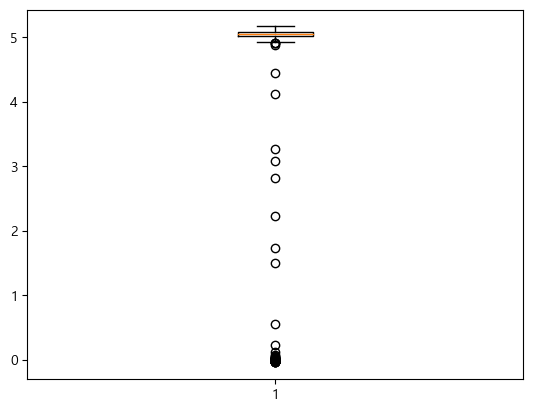

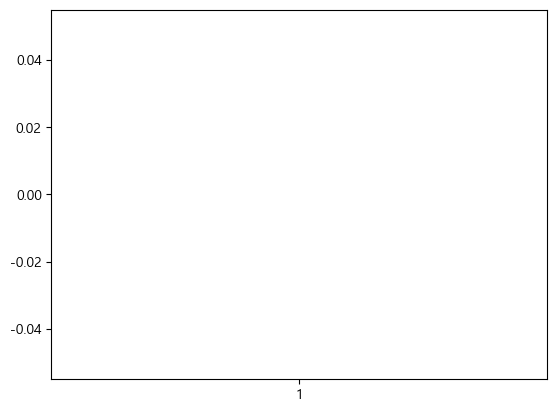

In [61]:

outlier_check(df_new[process].values)
print(limt_ttl[process])

count    5009.000000
mean        5.056275
std         0.102282
min         1.510000
25%         5.030000
50%         5.060000
75%         5.090000
max         5.170000
Name: DC 5V 전원 검사, dtype: float64



mean  5.056274705530045
usl: 5.148328466458099, lsl: 4.953992748943318
ucl: 5.15, lcl: 4.85




date     qty  DC 5V 전원 검사 Status  anomal_detection
0     20230215   94008         5.05     OK                 0
1     20230215   94133         5.04     OK                 0
2     20230215   94206         5.11     OK                 0
3     20230215   94240         5.06     OK                 0
4     20230215   94332         5.07     OK                 0
...        ...     ...          ...    ...               ...
5312  20230215  113424         5.04     OK                 0
5313  20230215  113455         5.08     OK                 0
5314  20230215  113509         0.00  JP1.1                 1
5315  20230215  113530         5.08     OK                 0
5316  20230215  114544         5.07     OK                 0

[5317 rows x 5 columns]



[0 0 0 ... 1 0 0]


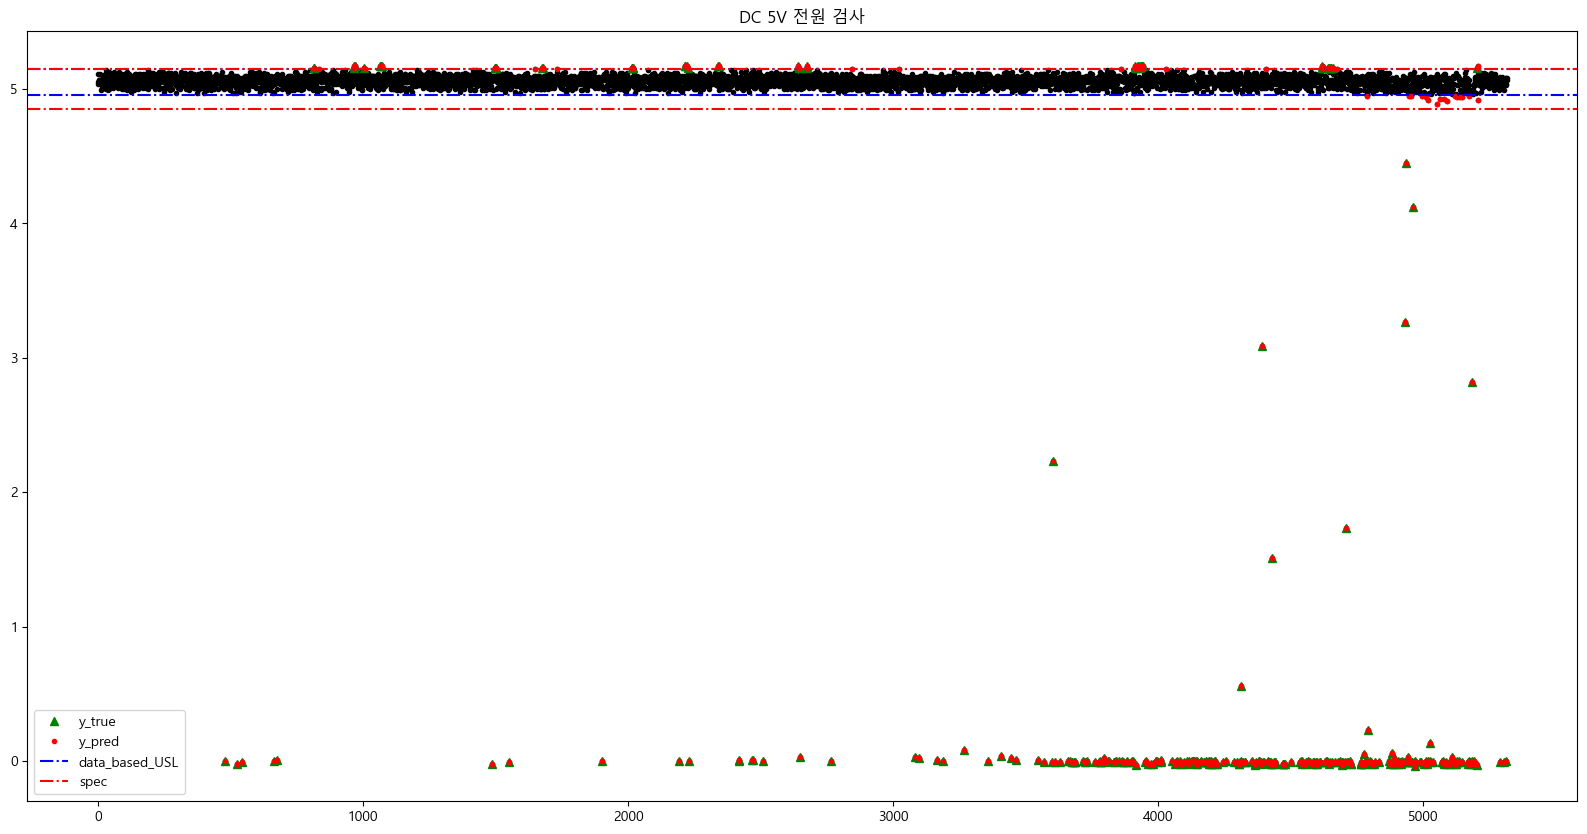

In [65]:
statistic_anomaly_detection(df_in=df_new, process=process, upper_sig=0.9, under_sig=1)

## 'SENSOR0 (TRA)'

In [67]:
process = 'SENSOR0 (TRA)'

df_new = df_list[process]

df_new.isna().sum()

date             0
qty              0
SENSOR0 (TRA)    0
Status           0
dtype: int64

In [68]:
Significance_Test(df_in=df_new[process])

SHAPIRO Result : test-statistics : 0.03030550479888916, p-value : 0.0
KS Result : test-statistics : 0.9970468070254415, p-value : 0.0
Normal Result : test-statistics : 10189.381535336572, p-value : 0.0
AndersonResult(statistic=1865.935415234695, critical_values=array([0.576, 0.655, 0.786, 0.917, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))


3.12 3.12
3 sigma range : 2.669325193772285 3.5595973243875223
{'ucl': 3.3, 'lcl': 2.8}


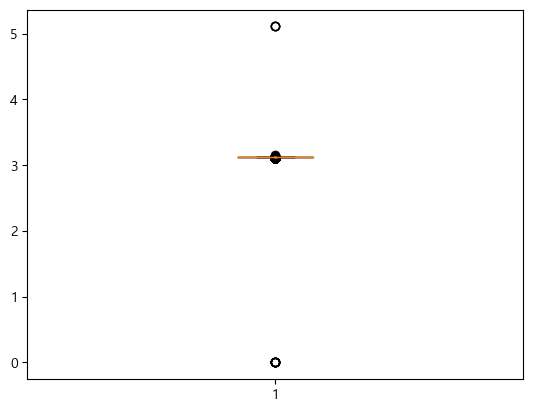

In [69]:

outlier_check(df_new[process].values)
print(limt_ttl[process])

In [76]:
statistic_anomaly_detection(df_in=df_new, process=process, upper_sig=6, under_sig=6)

count    4943.000000
mean        3.119551
std         0.002816
min         3.110000
25%         3.120000
50%         3.120000
75%         3.120000
max         3.160000
Name: SENSOR0 (TRA), dtype: float64



mean  3.1195508800323695
usl: 3.1364498126600613, lsl: 3.1026519474046776
ucl: 3.3, lcl: 2.8




date     qty  SENSOR0 (TRA) Status  anomal_detection
0     20230215   94008           3.11     OK                 0
1     20230215   94133           3.12     OK                 0
2     20230215   94206           3.12     OK                 0
3     20230215   94240           3.12     OK                 0
4     20230215   94332           3.12     OK                 0
...        ...     ...            ...    ...               ...
4951  20230215  113357           3.12     OK                 0
4952  20230215  113424           3.12     OK                 0
4953  20230215  113455           3.12     OK                 0
4954  20230215  113530           3.12     OK                 0
4955  20230215  114544           3.12     OK                 0

[4956 rows x 5 columns]



[0 0 0 ... 0 0 0]


## 'SENSOR1 (TDF)'

In [78]:
process = 'SENSOR1 (TDF)'

df_new = df_list[process]

df_new.isna().sum()

date             0
qty              0
SENSOR1 (TDF)    0
Status           0
dtype: int64

In [79]:
Significance_Test(df_in=df_new[process])

SHAPIRO Result : test-statistics : 0.03281223773956299, p-value : 0.0
KS Result : test-statistics : 0.9995499127594079, p-value : 0.0
Normal Result : test-statistics : 12567.100019222926, p-value : 0.0
AndersonResult(statistic=1648.222525819101, critical_values=array([0.576, 0.655, 0.786, 0.917, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))


3.33 3.33
3 sigma range : 3.1444440737562327 3.5175401654840175
{'ucl': 3.5, 'lcl': 3.1}


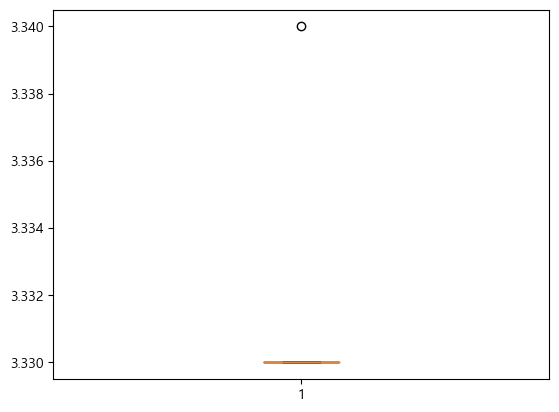

In [80]:

outlier_check(df_new[process].values)
print(limt_ttl[process])

count    4943.000000
mean        3.328833
std         0.005008
min         3.320000
25%         3.330000
50%         3.330000
75%         3.330000
max         3.350000
Name: SENSOR1 (TDF), dtype: float64



mean  3.3288326926967424
usl: 3.3588829909031177, lsl: 3.298782394490367
ucl: 3.5, lcl: 3.1




date     qty  SENSOR1 (TDF) Status  anomal_detection
0     20230215   94008           3.33     OK                 0
1     20230215   94133           3.33     OK                 0
2     20230215   94206           3.34     OK                 0
3     20230215   94240           3.34     OK                 0
4     20230215   94332           3.34     OK                 0
...        ...     ...            ...    ...               ...
4944  20230215  113357           3.33     OK                 0
4945  20230215  113424           3.32     OK                 0
4946  20230215  113455           3.33     OK                 0
4947  20230215  113530           3.33     OK                 0
4948  20230215  114544           3.32     OK                 0

[4949 rows x 5 columns]



[0 0 0 ... 0 0 0]


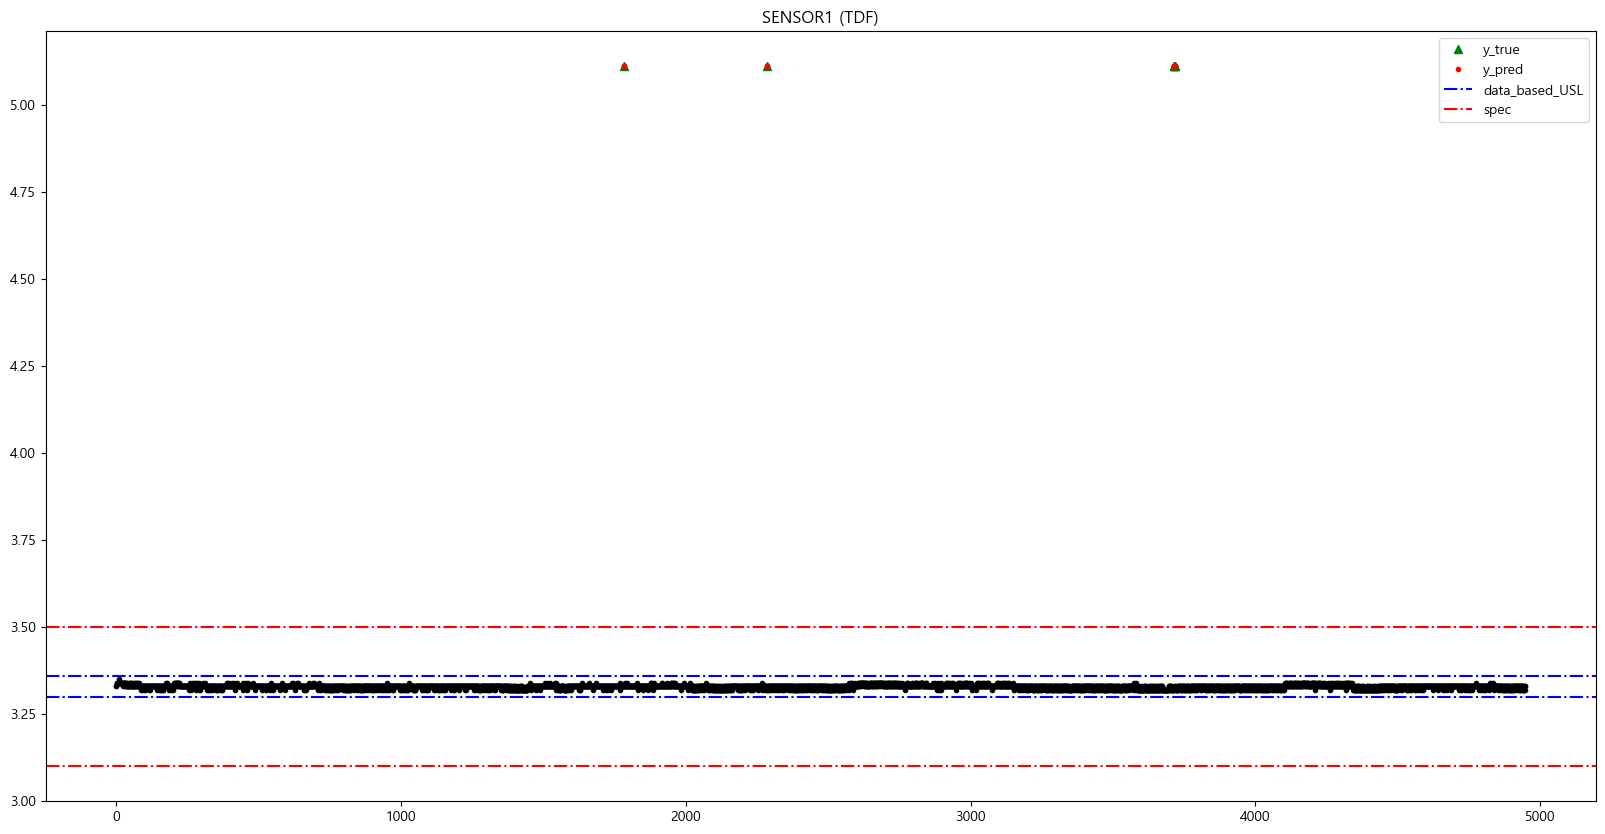

In [81]:
statistic_anomaly_detection(df_in=df_new, process=process, upper_sig=6, under_sig=6)

## 'DISP MOSI HIGH'

In [85]:
process = 'DISP MOSI HIGH'

df_new = df_list[process]

df_new.isna().sum()

date              0
qty               0
DISP MOSI HIGH    0
Status            0
dtype: int64

In [86]:
Significance_Test(df_in=df_new[process])

SHAPIRO Result : test-statistics : 0.2264460325241089, p-value : 0.0
KS Result : test-statistics : 0.952041211852477, p-value : 0.0
Normal Result : test-statistics : 4394.954691019484, p-value : 0.0
AndersonResult(statistic=1832.156868134185, critical_values=array([0.576, 0.655, 0.786, 0.917, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))


d:\MHC\2022\개인자료\kmong\lstm_즐거운샤프란\power_venv\p_venv\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


5.1 5.12
3 sigma range : 1.691621465537597 8.058952494400769
{'ucl': 5.15, 'lcl': 4.85}


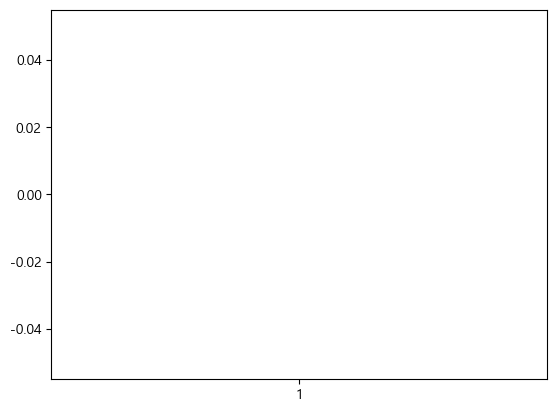

In [87]:
outlier_check(df_new[process].values)
print(limt_ttl[process])

count    4952.000000
mean        5.107300
std         0.121109
min         2.260000
25%         5.110000
50%         5.120000
75%         5.120000
max         5.120000
Name: DISP MOSI HIGH, dtype: float64



mean  5.107300080775444
usl: 5.131521839878728, lsl: 4.865082489742607
ucl: 5.15, lcl: 4.85




date     qty  DISP MOSI HIGH          Status  anomal_detection
0     20230215   93936            0.00  CN9.3, DC전압 검출                 1
1     20230215   94008            5.12              OK                 0
2     20230215   94133            5.12              OK                 0
3     20230215   94206            5.12              OK                 0
4     20230215   94240            5.12              OK                 0
...        ...     ...             ...             ...               ...
5187  20230215  113357            5.10              OK                 0
5188  20230215  113424            5.12              OK                 0
5189  20230215  113455            5.12              OK                 0
5190  20230215  113530            5.12              OK                 0
5191  20230215  114544            5.12              OK                 0

[5192 rows x 5 columns]



[1 0 0 ... 0 0 0]


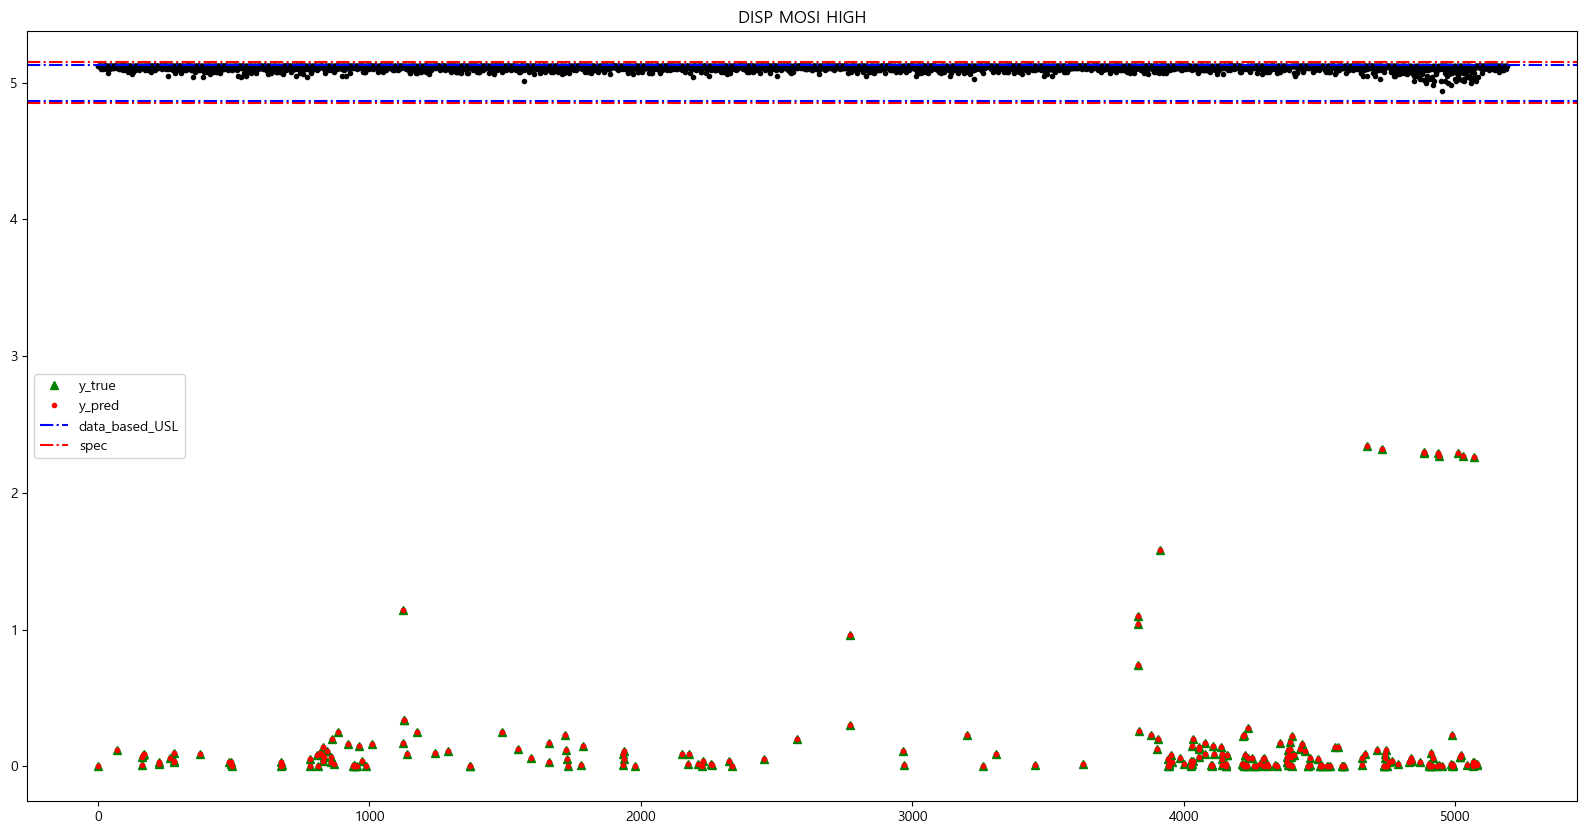

In [99]:
statistic_anomaly_detection(df_in=df_new, process=process, upper_sig=0.2, under_sig=2)

## 'DISP MISO HIGH'

In [101]:
process = 'DISP MISO HIGH'

df_new = df_list[process]

df_new.isna().sum()

date              0
qty               0
DISP MISO HIGH    0
Status            0
dtype: int64

In [102]:
Significance_Test(df_in=df_new[process])

SHAPIRO Result : test-statistics : 0.059732794761657715, p-value : 0.0
KS Result : test-statistics : 0.9945670696620511, p-value : 0.0
Normal Result : test-statistics : 9019.645480495583, p-value : 0.0
AndersonResult(statistic=1774.3480501798676, critical_values=array([0.576, 0.655, 0.786, 0.917, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))


5.1 5.12
3 sigma range : 4.076603764082957 6.098651769116236
{'ucl': 5.15, 'lcl': 4.85}


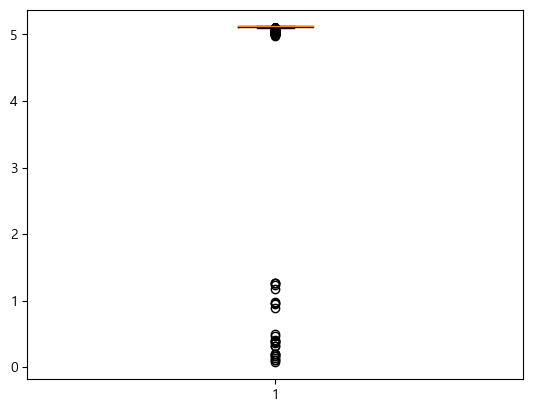

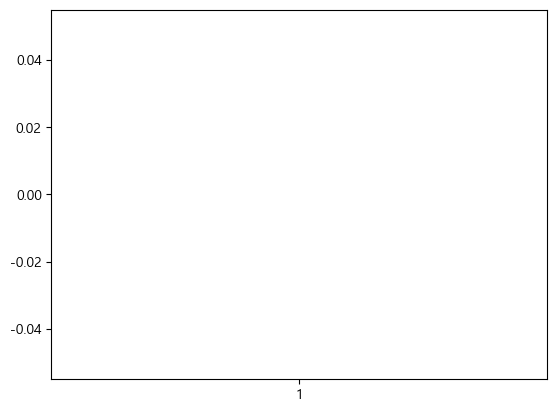

In [103]:
outlier_check(df_new[process].values)
print(limt_ttl[process])

count    4943.000000
mean        5.112405
std         0.015071
min         4.970000
25%         5.110000
50%         5.120000
75%         5.120000
max         5.120000
Name: DISP MISO HIGH, dtype: float64



mean  5.112405421808618
usl: 5.142547397132121, lsl: 5.021979495838107
ucl: 5.15, lcl: 4.85




date     qty  DISP MISO HIGH Status  anomal_detection
0     20230215   94008            5.12     OK                 0
1     20230215   94133            5.11     OK                 0
2     20230215   94206            5.12     OK                 0
3     20230215   94240            5.12     OK                 0
4     20230215   94332            5.12     OK                 0
...        ...     ...             ...    ...               ...
4965  20230215  113357            5.12     OK                 0
4966  20230215  113424            5.12     OK                 0
4967  20230215  113455            5.12     OK                 0
4968  20230215  113530            5.12     OK                 0
4969  20230215  114544            5.12     OK                 0

[4970 rows x 5 columns]



[0 0 0 ... 0 0 0]


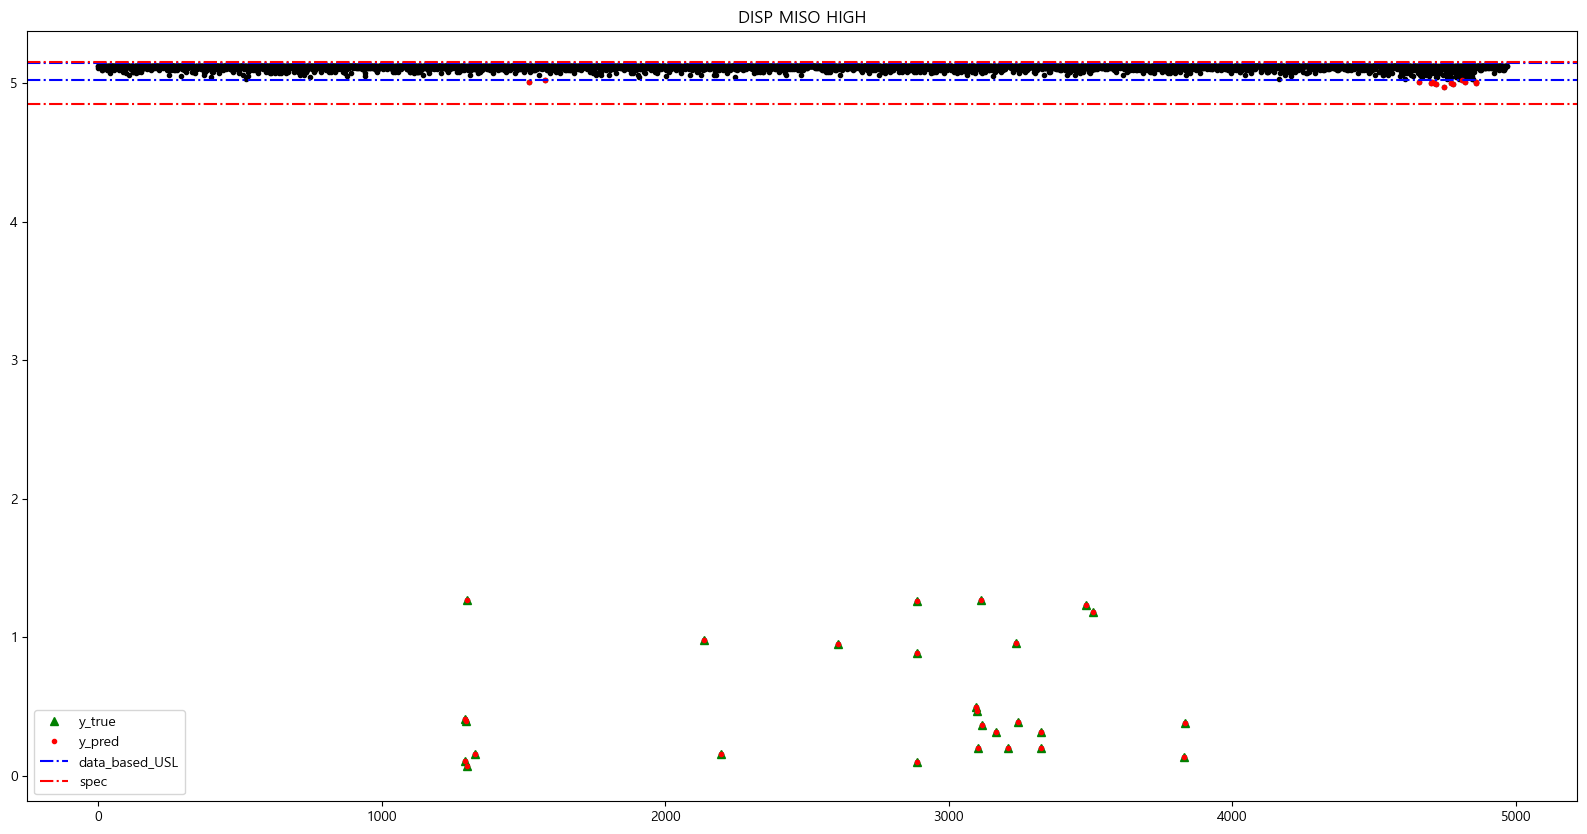

In [108]:
statistic_anomaly_detection(df_in=df_new, process=process, upper_sig=2, under_sig=6)

## 'DISP CLK HIGH'

In [110]:
process = 'DISP CLK HIGH'

df_new = df_list[process]

df_new.isna().sum()

date             0
qty              0
DISP CLK HIGH    0
Status           0
dtype: int64

In [111]:
Significance_Test(df_in=df_new[process])

SHAPIRO Result : test-statistics : 0.035931944847106934, p-value : 0.0
KS Result : test-statistics : 0.9985854875184507, p-value : 0.0
Normal Result : test-statistics : 12318.504817987194, p-value : 0.0
AndersonResult(statistic=1652.2940813477153, critical_values=array([0.576, 0.655, 0.786, 0.917, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))


5.1 5.12
3 sigma range : 4.606429137587325 5.60632641796823
{'ucl': 5.15, 'lcl': 4.85}


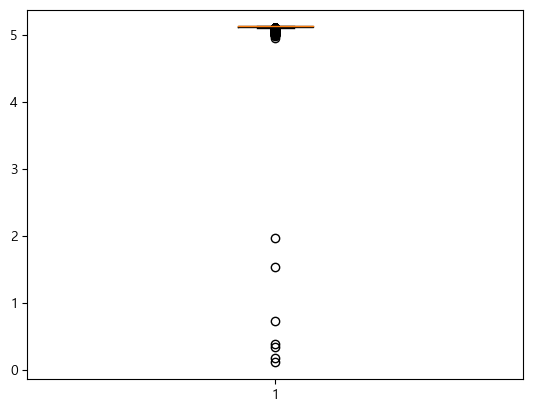

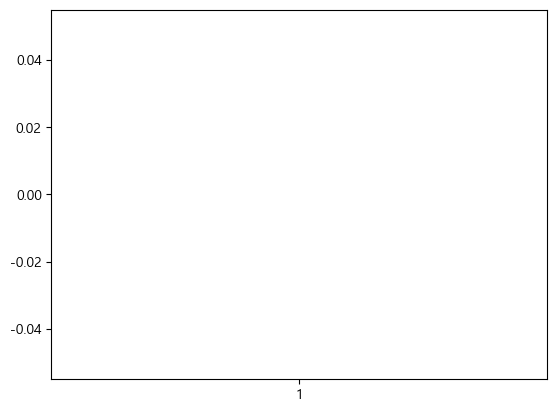

In [112]:
outlier_check(df_new[process].values)
print(limt_ttl[process])

count    4943.000000
mean        5.112551
std         0.015258
min         4.950000
25%         5.110000
50%         5.120000
75%         5.120000
max         5.120000
Name: DISP CLK HIGH, dtype: float64



mean  5.11255108233866
usl: 5.14306709311276, lsl: 5.021003050016362
ucl: 5.15, lcl: 4.85




date     qty  DISP CLK HIGH Status  anomal_detection
0     20230215   94008           5.12     OK                 0
1     20230215   94133           5.10     OK                 0
2     20230215   94206           5.12     OK                 0
3     20230215   94240           5.12     OK                 0
4     20230215   94332           5.12     OK                 0
...        ...     ...            ...    ...               ...
4945  20230215  113357           5.11     OK                 0
4946  20230215  113424           5.12     OK                 0
4947  20230215  113455           5.12     OK                 0
4948  20230215  113530           5.12     OK                 0
4949  20230215  114544           5.12     OK                 0

[4950 rows x 5 columns]



[0 0 0 ... 0 0 0]


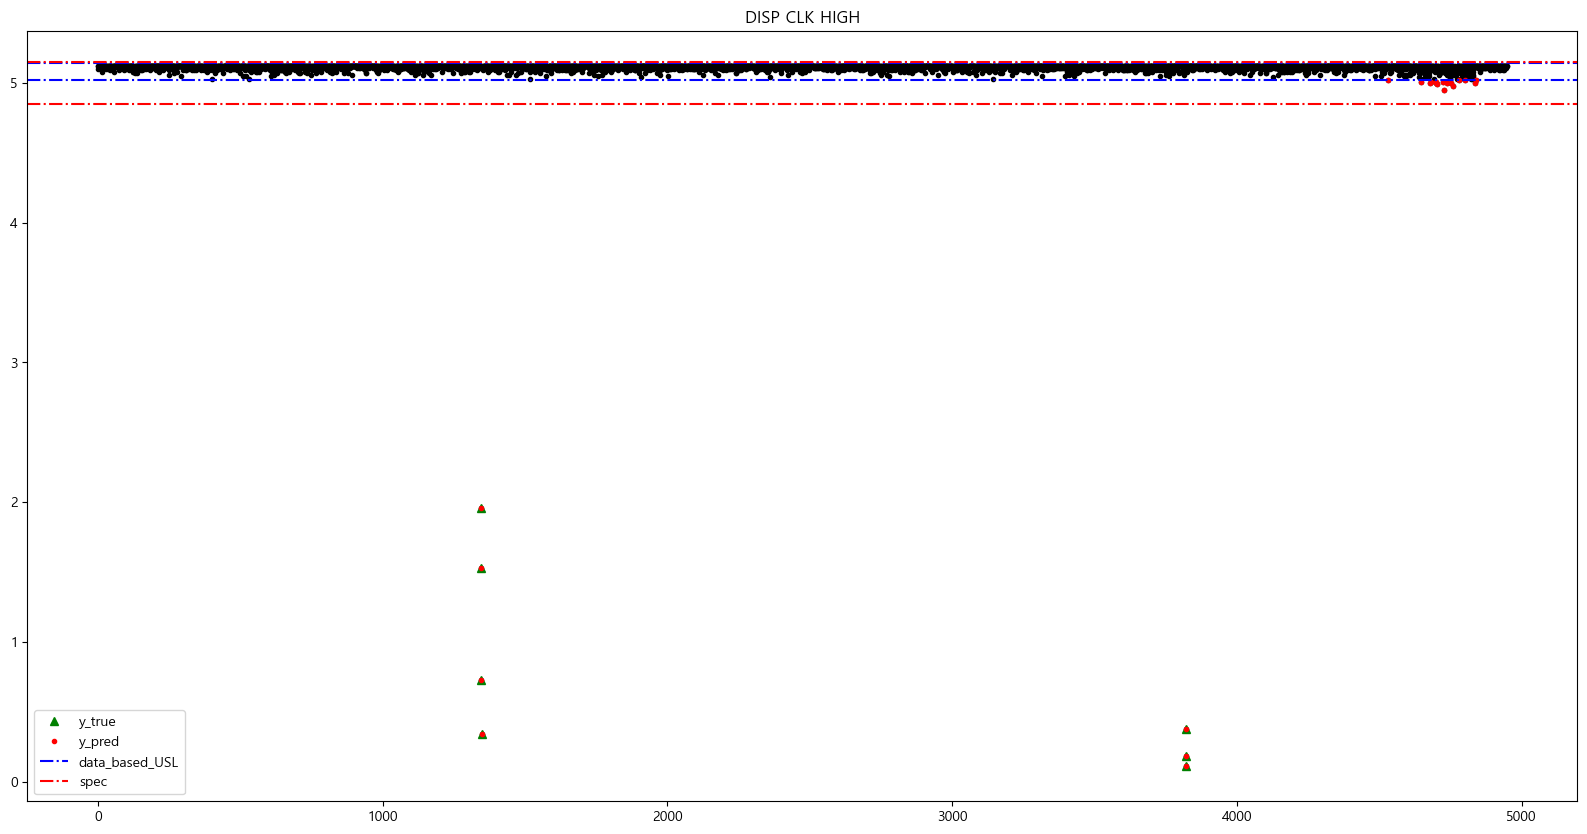

In [113]:
statistic_anomaly_detection(df_in=df_new, process=process, upper_sig=2, under_sig=6)

## 'DISP STB HIGH'

In [115]:
process = 'DISP STB HIGH'

df_new = df_list[process]

df_new.isna().sum()

date             0
qty              0
DISP STB HIGH    0
Status           0
dtype: int64

In [116]:
Significance_Test(df_in=df_new[process])

SHAPIRO Result : test-statistics : 0.04049307107925415, p-value : 0.0
KS Result : test-statistics : 0.9977792195970813, p-value : 0.0
Normal Result : test-statistics : 11127.12689142221, p-value : 0.0
AndersonResult(statistic=1700.9965375188385, critical_values=array([0.576, 0.655, 0.786, 0.917, 1.091]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))


5.1 5.12
3 sigma range : 4.486735089817833 5.719393291288343
{'ucl': 5.15, 'lcl': 4.85}


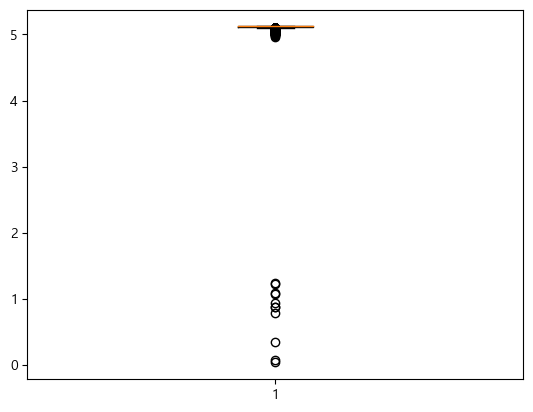

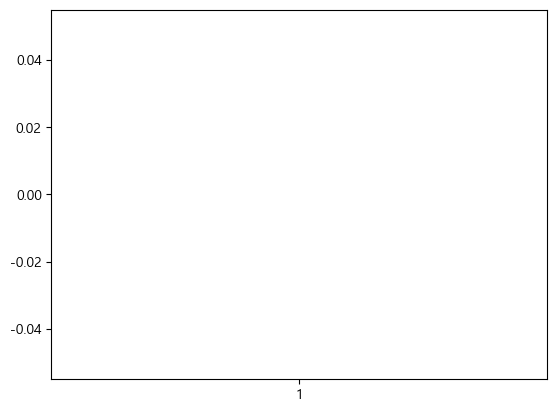

In [117]:
outlier_check(df_new[process].values)
print(limt_ttl[process])

In [120]:
statistic_anomaly_detection(df_in=df_new, process=process, upper_sig=2, under_sig=6)

count    4943.000000
mean        5.112687
std         0.014940
min         4.960000
25%         5.110000
50%         5.120000
75%         5.120000
max         5.120000
Name: DISP STB HIGH, dtype: float64



mean  5.112686627554117
usl: 5.142567296550464, lsl: 5.023044620565077
ucl: 5.15, lcl: 4.85




date     qty  DISP STB HIGH Status  anomal_detection
0     20230215   94008           5.12     OK                 0
1     20230215   94133           5.12     OK                 0
2     20230215   94206           5.12     OK                 0
3     20230215   94240           5.12     OK                 0
4     20230215   94332           5.12     OK                 0
...        ...     ...            ...    ...               ...
4949  20230215  113357           5.12     OK                 0
4950  20230215  113424           5.12     OK                 0
4951  20230215  113455           5.12     OK                 0
4952  20230215  113530           5.12     OK                 0
4953  20230215  114544           5.12     OK                 0

[4954 rows x 5 columns]



[0 0 0 ... 0 0 0]
